<a href="https://colab.research.google.com/github/Jinukki/KJU/blob/master/AutoencoderMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

In [22]:
EPOCH = 30
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')
print('Using Device', DEVICE)

Using Device cuda


In [5]:
trainset = datasets.MNIST(root='./data/', train=True, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(nn.Linear(28*28,128), nn.ReLU(), nn.Linear(128,64), nn.ReLU(), nn.Linear(64,12), nn.ReLU(), nn.Linear(12,3),)
    self.decoder = nn.Sequential(nn.Linear(3,12), nn.ReLU(), nn.Linear(12,64), nn.ReLU(), nn.Linear(64,128), nn.ReLU(), nn.Linear(128,28*28), nn.Sigmoid(),)
  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [0]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [0]:
view_data = trainset.data[:5].view(-1,28*28)
view_data = view_data.type(torch.FloatTensor)/255.

[Epoch 1]


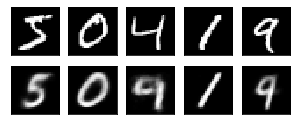

[Epoch 2]


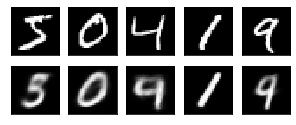

[Epoch 3]


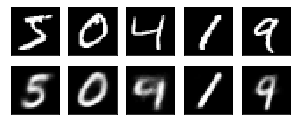

[Epoch 4]


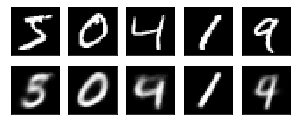

[Epoch 5]


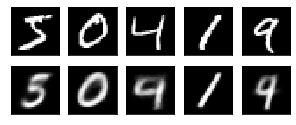

[Epoch 6]


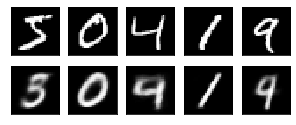

[Epoch 7]


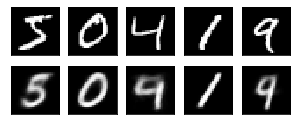

[Epoch 8]


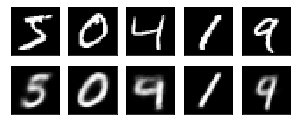

[Epoch 9]


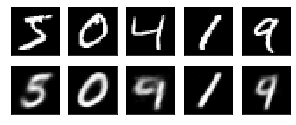

[Epoch 10]


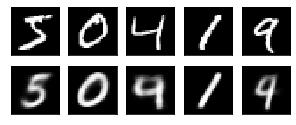

[Epoch 11]


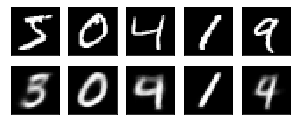

[Epoch 12]


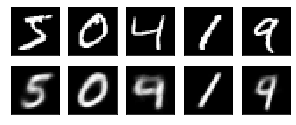

[Epoch 13]


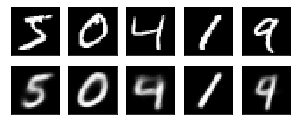

[Epoch 14]


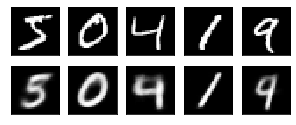

[Epoch 15]


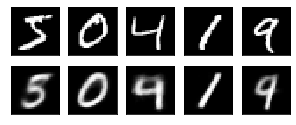

[Epoch 16]


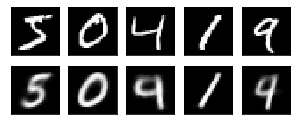

[Epoch 17]


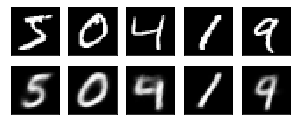

[Epoch 18]


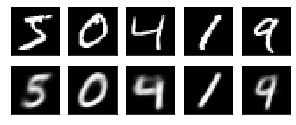

[Epoch 19]


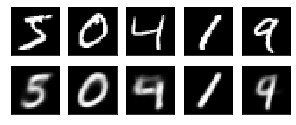

[Epoch 20]


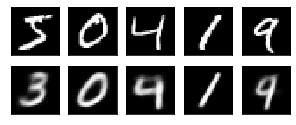

[Epoch 21]


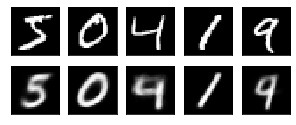

[Epoch 22]


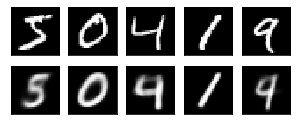

[Epoch 23]


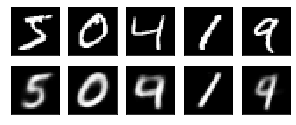

[Epoch 24]


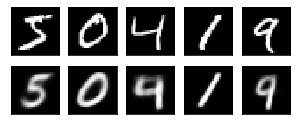

[Epoch 25]


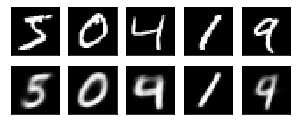

[Epoch 26]


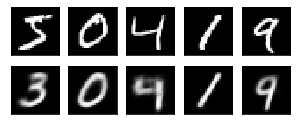

[Epoch 27]


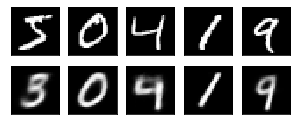

[Epoch 28]


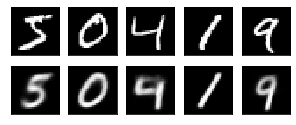

[Epoch 29]


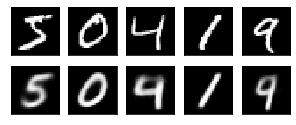

[Epoch 30]


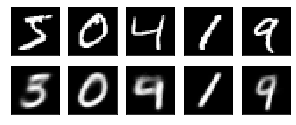

In [23]:
def train(autoencoder, train_loader):
  autoencoder.train()
  for step, (x, label) in enumerate(train_loader):
    x = x.view(-1, 28*28).to(DEVICE)
    y = x.view(-1, 28*28).to(DEVICE)
    label = label.to(DEVICE)

    encoded, decoded = autoencoder(x)

    loss = criterion(decoded, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

for epoch in range(1, EPOCH+1):
  train(autoencoder, train_loader)
  test_x = view_data.to(DEVICE)
  _, decoded_data = autoencoder(test_x)

  f, a = plt.subplots(2, 5, figsize=(5,2))
  print('[Epoch {}]'.format(epoch))

  for i in range(5):
    img = np.reshape(view_data.data.numpy()[i], (28,28))
    a[0][i].imshow(img, cmap='gray')
    a[0][i].set_xticks(()); a[0][i].set_yticks(())

  for i in range(5):
    img = np.reshape(decoded_data.to('cpu').data.numpy()[i], (28,28))
    a[1][i].imshow(img, cmap='gray')
    a[1][i].set_xticks(()); a[1][i].set_yticks(())

  plt.show()

In [40]:
from torchsummary import summary
summary(autoencoder, (1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]         100,480
              ReLU-2               [-1, 1, 128]               0
            Linear-3                [-1, 1, 64]           8,256
              ReLU-4                [-1, 1, 64]               0
            Linear-5                [-1, 1, 12]             780
              ReLU-6                [-1, 1, 12]               0
            Linear-7                 [-1, 1, 3]              39
            Linear-8                [-1, 1, 12]              48
              ReLU-9                [-1, 1, 12]               0
           Linear-10                [-1, 1, 64]             832
             ReLU-11                [-1, 1, 64]               0
           Linear-12               [-1, 1, 128]           8,320
             ReLU-13               [-1, 1, 128]               0
           Linear-14               [-1,

In [38]:
sum([param.nelement() for param in autoencoder.parameters()])

219891

In [33]:
print(autoencoder)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


In [0]:
view_data = trainset.data[:200].view(-1,28*28)
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE)
encoded_data, _ = autoencoder(test_x)
encoded_data = encoded_data.to('cpu')

In [42]:
def add_noise(img):
  noise = torch.randn(img.size()) * 0.2
  noisy_img = img + noise
  return noisy_img

def train(autoencoder, train_loader):
  autoencoder.train()
  avg_loss = 0
  for step, (x, label) in enumerate(train_loader):
    x = add_noise(x)
    x = x.view(-1, 28*28).to(DEVICE)
    y = x.view(-1, 28*28).to(DEVICE)
    label = label.to(DEVICE)

    encoded, decoded = autoencoder(x)

    loss = criterion(decoded, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    avg_loss += loss.item()
  return avg_loss / len(train_loader)

for epoch in range(1, EPOCH+1):
  loss = train(autoencoder, train_loader)
  print('[Epoch {}] loss:{}'.format(epoch, loss))

[Epoch 1] loss:0.07457046902605466
[Epoch 2] loss:0.0738383043311171
[Epoch 3] loss:0.07362774918392015
[Epoch 4] loss:0.07378816614145918
[Epoch 5] loss:0.07339696488432539
[Epoch 6] loss:0.07324482347252273
[Epoch 7] loss:0.07307393401702329
[Epoch 8] loss:0.07305278807783178
[Epoch 9] loss:0.0729688247765051
[Epoch 10] loss:0.07295352449295109
[Epoch 11] loss:0.07302771476127191
[Epoch 12] loss:0.07288393371903312
[Epoch 13] loss:0.07274904894803379
[Epoch 14] loss:0.07308043184469758
[Epoch 15] loss:0.07292575594871792
[Epoch 16] loss:0.07288400549243
[Epoch 17] loss:0.07271217854260635
[Epoch 18] loss:0.07288047052554485
[Epoch 19] loss:0.0726489323749344
[Epoch 20] loss:0.07269671677685241
[Epoch 21] loss:0.07327912935315928
[Epoch 22] loss:0.07305784559230814
[Epoch 23] loss:0.07295992263535192
[Epoch 24] loss:0.07287255395005253
[Epoch 25] loss:0.07266756662650149
[Epoch 26] loss:0.07264769069357976
[Epoch 27] loss:0.07267914623466891
[Epoch 28] loss:0.07250941205602973
[Epoch 

In [0]:
testset = datasets.MNIST(root='./data/', train=False, download=True, transform=transforms.ToTensor())

In [0]:
sample_data = testset.data[0].view(-1,28*28)
sample_data = sample_data.type(torch.FloatTensor)/255.

In [0]:
original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x)

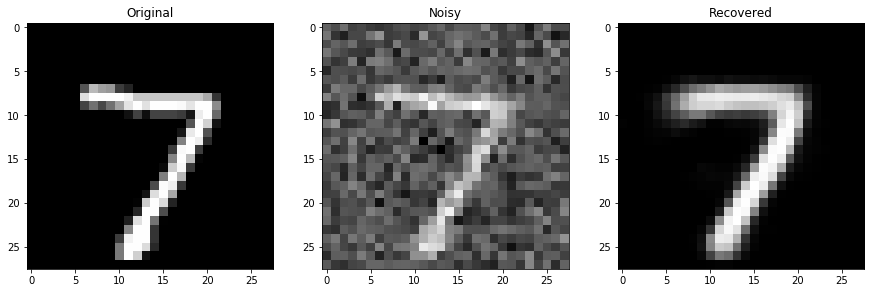

In [46]:
f, a = plt.subplots(1, 3, figsize=(15,15))

original_img = np.reshape(original_x.to('cpu').data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to('cpu').data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to('cpu').data.numpy(), (28, 28))

a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()

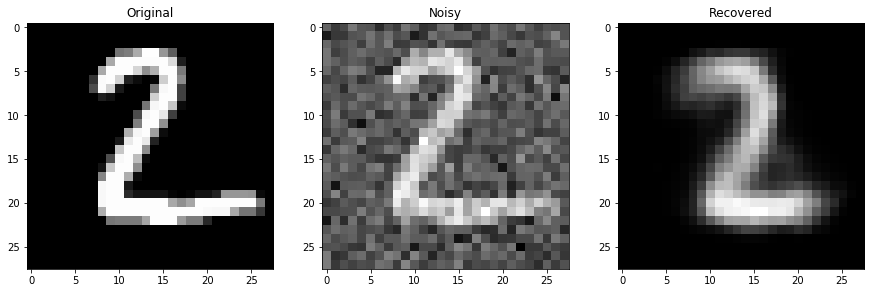

In [47]:
sample_data = testset.data[1].view(-1,28*28)
sample_data = sample_data.type(torch.FloatTensor)/255.

original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x)

f, a = plt.subplots(1, 3, figsize=(15,15))

original_img = np.reshape(original_x.to('cpu').data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to('cpu').data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to('cpu').data.numpy(), (28, 28))

a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()

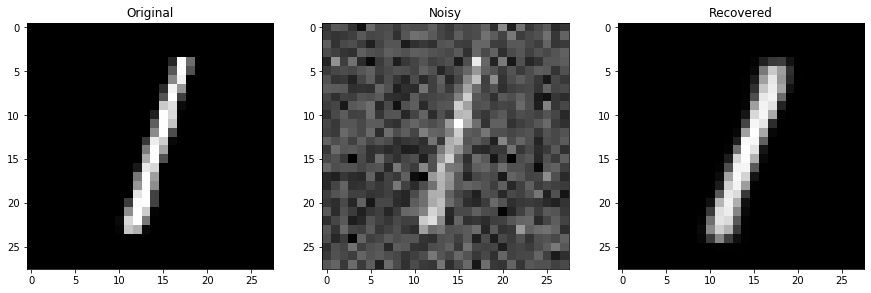

In [48]:
sample_data = testset.data[2].view(-1,28*28)
sample_data = sample_data.type(torch.FloatTensor)/255.

original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x)

f, a = plt.subplots(1, 3, figsize=(15,15))

original_img = np.reshape(original_x.to('cpu').data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to('cpu').data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to('cpu').data.numpy(), (28, 28))

a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()

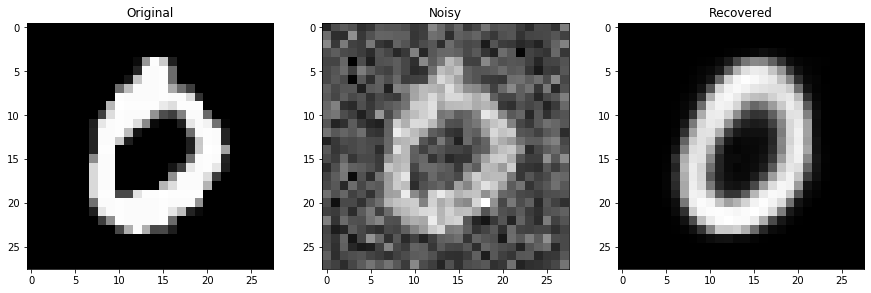

In [49]:
sample_data = testset.data[3].view(-1,28*28)
sample_data = sample_data.type(torch.FloatTensor)/255.

original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x)

f, a = plt.subplots(1, 3, figsize=(15,15))

original_img = np.reshape(original_x.to('cpu').data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to('cpu').data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to('cpu').data.numpy(), (28, 28))

a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()